# Analyse Exploratoire - GBP/USD M15

Exploration des données M15 nettoyées : prix, rendements, volatilité, autocorrélation, stationnarité.

**Données** : 2022 (train), 2023 (val), 2024 (test) — bougies 15 min.

## Section 1 : Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Config plotly
import plotly.io as pio
pio.templates.default = "plotly_dark"

# Config matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
sns.set_style('darkgrid')

# Chemins
PROJECT_ROOT = Path('..').resolve()
RESULTS_DIR = PROJECT_ROOT / 'data' / 'processed'

# Chargement des splits
df_train = pd.read_parquet(PROJECT_ROOT / 'data/splits/train.parquet')
df_val = pd.read_parquet(PROJECT_ROOT / 'data/splits/val.parquet')
df_test = pd.read_parquet(PROJECT_ROOT / 'data/splits/test.parquet')

for name, df in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    print(f"{name:5s}: {len(df):>6,} candles | {df['timestamp'].min().date()} -> {df['timestamp'].max().date()}")

print(f"\nTotal: {len(df_train) + len(df_val) + len(df_test):,} candles")

Train: 24,247 candles | 2022-01-02 -> 2022-12-30
Val  : 21,048 candles | 2023-01-01 -> 2023-12-29
Test : 23,825 candles | 2024-01-01 -> 2024-12-31

Total: 69,120 candles


## Section 2 : Vue d'ensemble des données

### 2.1 - Infos basiques

In [2]:
print("=== Train Set ===")
print(f"Shape: {df_train.shape}")
print(f"Colonnes: {df_train.columns.tolist()}")
print(f"NaN: {df_train.isna().sum().sum()}")
print()
df_train.describe()

=== Train Set ===
Shape: (24247, 10)
Colonnes: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'hour', 'day_of_week', 'is_session_start', 'is_gap']
NaN: 0



,timestamp,open,high,low,close,volume,hour,day_of_week
count,24247,24247.000000,24247.000000,24247.000000,24247.000000,24247.0,24247.000000,24247.000000
mean,2022-07-03 02:41:15.064956416,1.236312,1.236922,1.235699,1.236305,0.0,11.349074,2.115767
min,2022-01-02 17:45:00,1.039970,1.051140,1.032610,1.040000,0.0,0.000000,0.000000
25%,2022-04-04 00:37:30,1.184765,1.185510,1.183935,1.184755,0.0,5.000000,1.000000
50%,2022-07-04 06:00:00,1.221850,1.222480,1.221170,1.221850,0.0,11.000000,2.000000
75%,2022-10-03 01:37:30,1.307825,1.308405,1.307460,1.307820,0.0,18.000000,3.000000
max,2022-12-30 16:30:00,1.374630,1.374870,1.374000,1.374610,0.0,23.000000,6.000000
std,NaN,0.076136,0.075970,0.076291,0.076134,0.0,6.952554,1.628112


In [3]:
# Vérification NaN par split
for name, df in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    nan_count = df.isna().sum().sum()
    print(f"{name}: {nan_count} NaN")

Train: 0 NaN
Val: 0 NaN
Test: 0 NaN


### 2.2 - Prix OHLC dans le temps

In [4]:
# Concaténation avec label de split
df_all = pd.concat([
    df_train.assign(split='Train (2022)'),
    df_val.assign(split='Val (2023)'),
    df_test.assign(split='Test (2024)'),
], ignore_index=True)

# Échantillonnage pour plotly (1 bougie sur 4 = 1h)
df_plot = df_all.iloc[::4].copy()

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.75, 0.25],
    subplot_titles=['GBP/USD M15 - Close Price', 'Volume'],
)

colors = {'Train (2022)': '#00d4aa', 'Val (2023)': '#ffa726', 'Test (2024)': '#ef5350'}

for split_name in ['Train (2022)', 'Val (2023)', 'Test (2024)']:
    mask = df_plot['split'] == split_name
    sub = df_plot[mask]
    fig.add_trace(
        go.Scatter(
            x=sub['timestamp'], y=sub['close'],
            name=split_name, line=dict(color=colors[split_name], width=1),
        ),
        row=1, col=1,
    )
    fig.add_trace(
        go.Bar(
            x=sub['timestamp'], y=sub['volume'],
            name=f'Vol {split_name}', marker_color=colors[split_name],
            opacity=0.5, showlegend=False,
        ),
        row=2, col=1,
    )

# Lignes de séparation train/val/test
for date, label in [('2023-01-01', 'Train|Val'), ('2024-01-01', 'Val|Test')]:
    fig.add_vline(x=date, line_dash='dash', line_color='yellow', opacity=0.5, row=1, col=1)

fig.update_layout(height=600, title_text='GBP/USD - Vue d\'ensemble 2022-2024')
fig.update_yaxes(title_text='Prix (GBP/USD)', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)
fig.show()

## Section 3 : Distribution des rendements

### 3.1 - Calcul rendements

In [5]:
for df in [df_train, df_val, df_test]:
    df['return_1'] = df['close'].pct_change()
    df['return_log'] = np.log(df['close'] / df['close'].shift(1))

print("Rendements calculés (return_1, return_log) pour chaque split.")
df_train[['timestamp', 'close', 'return_1', 'return_log']].head()

Rendements calculés (return_1, return_log) pour chaque split.


,timestamp,close,return_1,return_log
0,2022-01-02 17:45:00,1.35269,NaN,NaN
1,2022-01-02 18:00:00,1.35258,-0.000081,-0.000081
2,2022-01-02 18:15:00,1.35240,-0.000133,-0.000133
3,2022-01-02 18:30:00,1.35230,-0.000074,-0.000074
4,2022-01-02 18:45:00,1.35216,-0.000104,-0.000104


### 3.2 - Histogramme + Q-Q plot

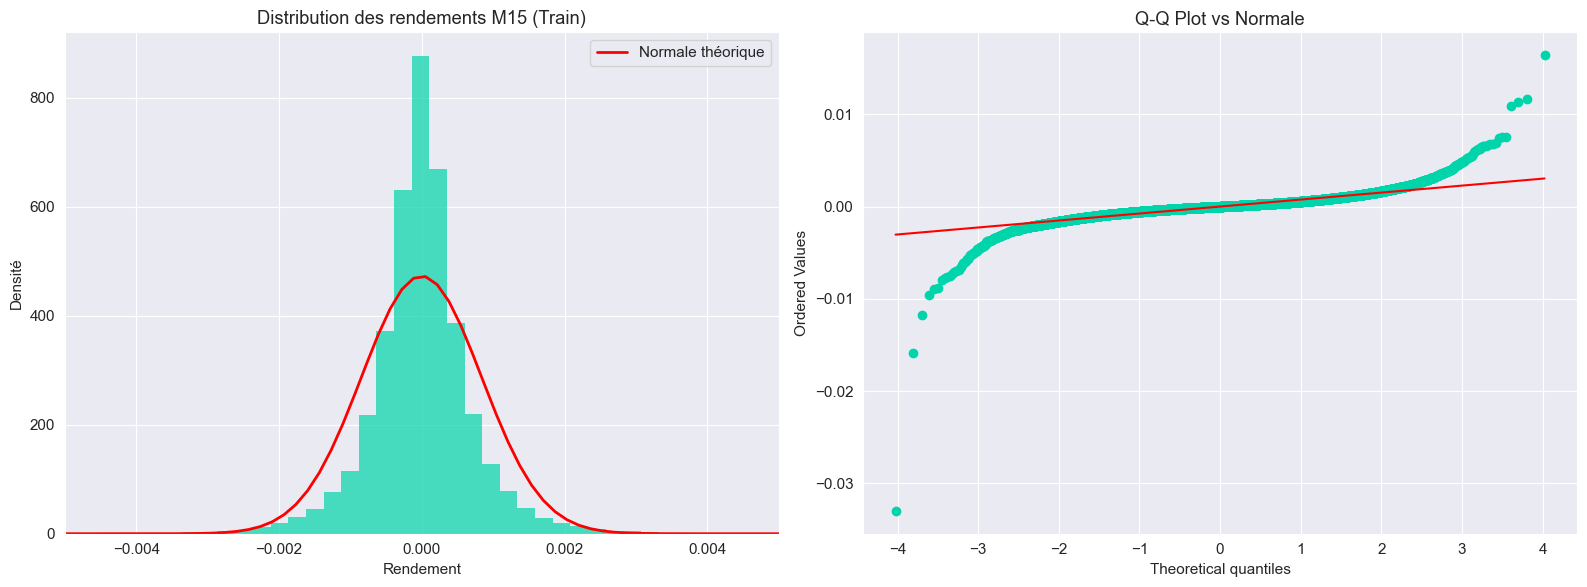

Mean:     -0.00000425
Std:      0.00084374
Skewness: -2.2967
Kurtosis: 122.5579  (excès, normale=0)

Shapiro-Wilk: stat=0.810160, p-value=1.31e-60
=> Rendements NON normaux (leptokurtiques, fat tails)


In [6]:
returns = df_train['return_1'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme
ax = axes[0]
ax.hist(returns, bins=200, density=True, alpha=0.7, color='#00d4aa', edgecolor='none')
x_range = np.linspace(returns.min(), returns.max(), 300)
ax.plot(x_range, scipy_stats.norm.pdf(x_range, returns.mean(), returns.std()),
        'r-', linewidth=2, label='Normale théorique')
ax.set_title('Distribution des rendements M15 (Train)')
ax.set_xlabel('Rendement')
ax.set_ylabel('Densité')
ax.legend()
ax.set_xlim(-0.005, 0.005)

# Q-Q plot
ax = axes[1]
scipy_stats.probplot(returns, dist='norm', plot=ax)
ax.set_title('Q-Q Plot vs Normale')
ax.get_lines()[0].set_color('#00d4aa')
ax.get_lines()[1].set_color('red')

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'returns_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

# Statistiques
print(f"Mean:     {returns.mean():.8f}")
print(f"Std:      {returns.std():.8f}")
print(f"Skewness: {returns.skew():.4f}")
print(f"Kurtosis: {returns.kurtosis():.4f}  (excès, normale=0)")

shapiro_stat, shapiro_p = scipy_stats.shapiro(returns.sample(min(5000, len(returns)), random_state=42))
print(f"\nShapiro-Wilk: stat={shapiro_stat:.6f}, p-value={shapiro_p:.2e}")
if shapiro_p < 0.05:
    print("=> Rendements NON normaux (leptokurtiques, fat tails)")
else:
    print("=> Rendements compatibles avec une loi normale")

### 3.3 - Rendements par période

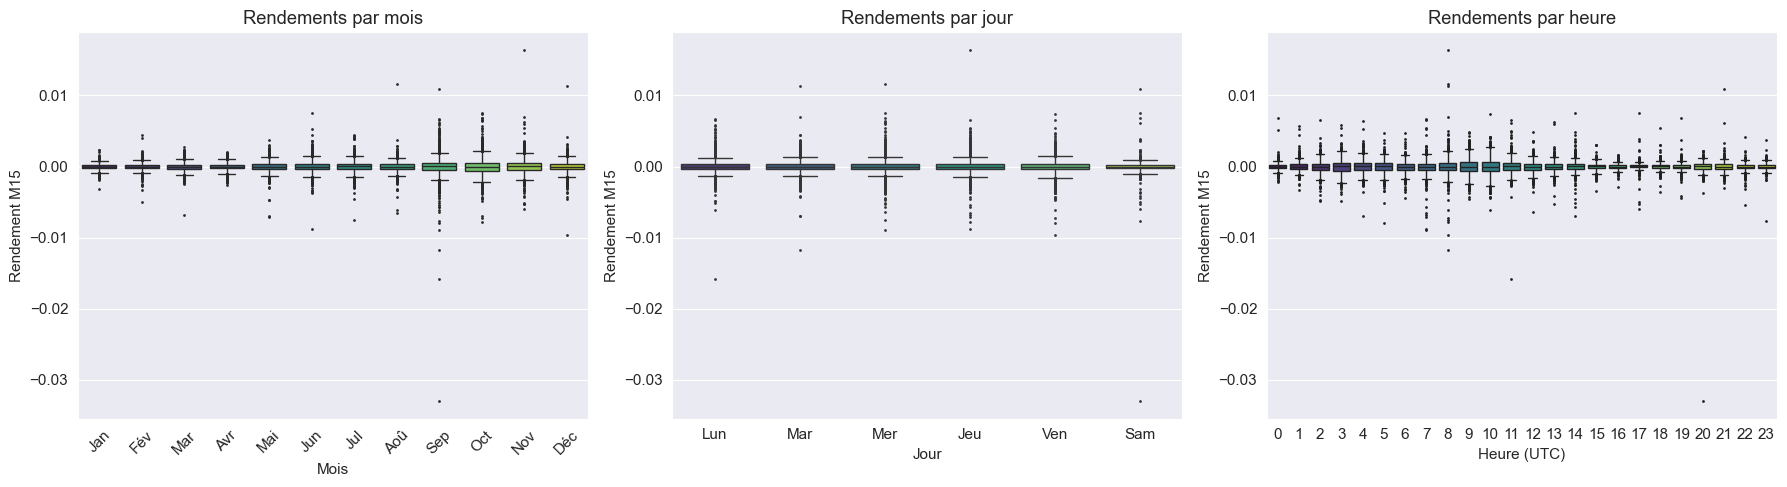

In [7]:
train_returns = df_train.dropna(subset=['return_1']).copy()
train_returns['month'] = train_returns['timestamp'].dt.month

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Par mois
month_labels = ['Jan','Fév','Mar','Avr','Mai','Jun','Jul','Aoû','Sep','Oct','Nov','Déc']
sns.boxplot(data=train_returns, x='month', y='return_1', ax=axes[0],
            fliersize=1, palette='viridis')
axes[0].set_xticklabels(month_labels, rotation=45)
axes[0].set_title('Rendements par mois')
axes[0].set_xlabel('Mois')
axes[0].set_ylabel('Rendement M15')

# Par jour de la semaine
day_labels = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
sns.boxplot(data=train_returns, x='day_of_week', y='return_1', ax=axes[1],
            fliersize=1, palette='viridis')
axes[1].set_xticklabels(day_labels)
axes[1].set_title('Rendements par jour')
axes[1].set_xlabel('Jour')
axes[1].set_ylabel('Rendement M15')

# Par heure
sns.boxplot(data=train_returns, x='hour', y='return_1', ax=axes[2],
            fliersize=1, palette='viridis')
axes[2].set_title('Rendements par heure')
axes[2].set_xlabel('Heure (UTC)')
axes[2].set_ylabel('Rendement M15')

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'returns_by_period.png'), dpi=150, bbox_inches='tight')
plt.show()

## Section 4 : Volatilité dans le temps

### 4.1 - Rolling Std

In [8]:
returns_series = df_train['return_1'].dropna()

fig = go.Figure()

windows = {
    20: ('Rolling Std 20 (~5h)', '#00d4aa'),
    100: ('Rolling Std 100 (~25h)', '#ffa726'),
    200: ('Rolling Std 200 (~50h)', '#ef5350'),
}

for w, (label, color) in windows.items():
    rolling = returns_series.rolling(w).std()
    # Sous-échantillonnage pour performance plotly
    idx = rolling.index[::4]
    fig.add_trace(go.Scatter(
        x=df_train.loc[idx, 'timestamp'],
        y=rolling.loc[idx],
        name=label,
        line=dict(color=color, width=1),
    ))

fig.update_layout(
    title='Volatilité réalisée (Rolling Std) - Train 2022',
    yaxis_title='Std des rendements',
    height=450,
)
fig.show()

### 4.2 - ATR (Average True Range)

In [9]:
def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """Calcule l'Average True Range."""
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(period).mean()

df_train['atr_14'] = calculate_atr(df_train, 14)

# Plot
atr_plot = df_train.iloc[::4].dropna(subset=['atr_14'])

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    row_heights=[0.6, 0.4],
                    subplot_titles=['GBP/USD Close (Train)', 'ATR-14'])

fig.add_trace(go.Scatter(x=atr_plot['timestamp'], y=atr_plot['close'],
                         name='Close', line=dict(color='#00d4aa', width=1)), row=1, col=1)

fig.add_trace(go.Scatter(x=atr_plot['timestamp'], y=atr_plot['atr_14'],
                         name='ATR-14', line=dict(color='#ffa726', width=1)), row=2, col=1)

# Seuils volatilité
atr_mean = df_train['atr_14'].mean()
atr_high = atr_mean + df_train['atr_14'].std()
fig.add_hline(y=atr_mean, line_dash='dash', line_color='white', opacity=0.5, row=2, col=1,
              annotation_text='Moyenne')
fig.add_hline(y=atr_high, line_dash='dash', line_color='red', opacity=0.5, row=2, col=1,
              annotation_text='Haute vol.')

fig.update_layout(height=500, title_text='Prix et ATR - Train 2022')
fig.show()

### 4.3 - Heatmap volatilité (Jour x Heure)

In [10]:
train_vol = df_train.dropna(subset=['return_1']).copy()

vol_pivot = train_vol.groupby(['day_of_week', 'hour'])['return_1'].std().reset_index()
vol_pivot = vol_pivot.pivot(index='hour', columns='day_of_week', values='return_1')

day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
# Ne garder que les colonnes existantes
existing_days = [d for d in range(7) if d in vol_pivot.columns]
vol_pivot = vol_pivot[existing_days]
col_labels = [day_names[d] for d in existing_days]

fig = go.Figure(data=go.Heatmap(
    z=vol_pivot.values,
    x=col_labels,
    y=[f'{h:02d}h' for h in vol_pivot.index],
    colorscale='YlOrRd',
    colorbar_title='Std rendements',
))

fig.update_layout(
    title='Volatilité par jour de la semaine et heure (Train 2022)',
    xaxis_title='Jour',
    yaxis_title='Heure (UTC)',
    height=550,
)
fig.show()

## Section 5 : Analyse horaire

### 5.1 - Volume moyen par heure

In [11]:
hourly_stats = df_train.groupby('hour').agg(
    volume_mean=('volume', 'mean'),
    return_mean=('return_1', 'mean'),
    return_std=('return_1', 'std'),
    n_candles=('close', 'count'),
).reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['volume_mean'],
    marker_color='#00d4aa',
    name='Volume moyen',
))

fig.update_layout(
    title='Volume moyen par heure (Train 2022)',
    xaxis_title='Heure (UTC)',
    yaxis_title='Volume moyen',
    height=400,
)
fig.show()

### 5.2 - Rendement moyen par heure

In [12]:
colors_bar = ['#ef5350' if v < 0 else '#00d4aa' for v in hourly_stats['return_mean']]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=hourly_stats['hour'],
    y=hourly_stats['return_mean'],
    marker_color=colors_bar,
    name='Rendement moyen',
))

fig.update_layout(
    title='Rendement moyen par heure (Train 2022)',
    xaxis_title='Heure (UTC)',
    yaxis_title='Rendement moyen',
    height=400,
)
fig.show()

### 5.3 - Patterns intraday

In [13]:
most_volatile_hour = int(hourly_stats.loc[hourly_stats['return_std'].idxmax(), 'hour'])
highest_volume_hour = int(hourly_stats.loc[hourly_stats['volume_mean'].idxmax(), 'hour'])
best_return_hour = int(hourly_stats.loc[hourly_stats['return_mean'].idxmax(), 'hour'])
worst_return_hour = int(hourly_stats.loc[hourly_stats['return_mean'].idxmin(), 'hour'])

intraday_patterns = {
    'most_volatile_hour': most_volatile_hour,
    'highest_volume_hour': highest_volume_hour,
    'best_return_hour': best_return_hour,
    'worst_return_hour': worst_return_hour,
    'max_volatility': float(hourly_stats['return_std'].max()),
    'max_volume': float(hourly_stats['volume_mean'].max()),
}

print("=== Patterns Intraday (Train 2022) ===")
print(f"Heure la plus volatile : {most_volatile_hour}h (std={hourly_stats['return_std'].max():.6f})")
print(f"Heure plus gros volume : {highest_volume_hour}h (vol={hourly_stats['volume_mean'].max():.0f})")
print(f"Meilleur rendement moyen : {best_return_hour}h ({hourly_stats['return_mean'].max():.8f})")
print(f"Pire rendement moyen : {worst_return_hour}h ({hourly_stats['return_mean'].min():.8f})")

=== Patterns Intraday (Train 2022) ===
Heure la plus volatile : 8h (std=0.001403)
Heure plus gros volume : 0h (vol=0)
Meilleur rendement moyen : 18h (0.00004300)
Pire rendement moyen : 12h (-0.00006285)


## Section 6 : Autocorrélation

### 6.1 - ACF Plots

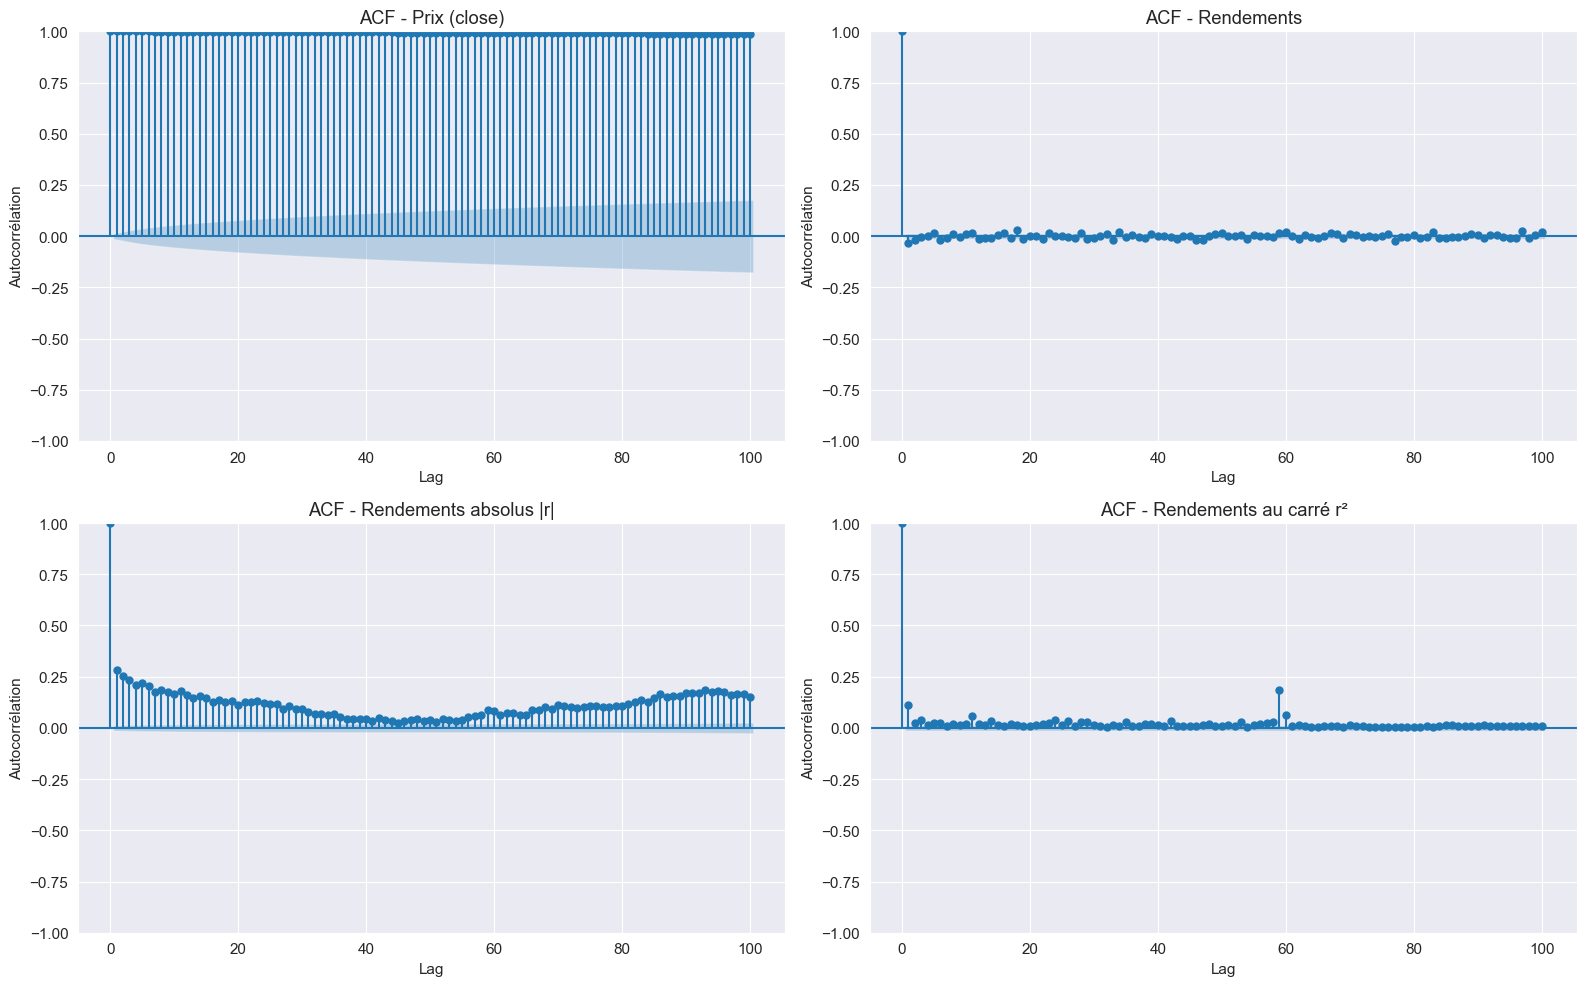

In [14]:
returns_clean = df_train['return_1'].dropna()
n_lags = 100

series_to_plot = {
    'Prix (close)': df_train['close'].dropna(),
    'Rendements': returns_clean,
    'Rendements absolus |r|': returns_clean.abs(),
    'Rendements au carré r²': returns_clean ** 2,
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, (title, series) in zip(axes.flat, series_to_plot.items()):
    plot_acf(series, lags=n_lags, ax=ax, alpha=0.05, title=f'ACF - {title}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrélation')

plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'acf_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.2 - Interprétation

**Prix (close)** : Forte autocorrélation persistante, décroissance très lente. Le prix est non-stationnaire (mémoire longue typique d'une marche aléatoire).

**Rendements** : Autocorrélation faible/nulle dès le lag 1. Les rendements sont proches d'un bruit blanc, ce qui est cohérent avec l'hypothèse d'efficience faible du marché forex.

**Rendements absolus et au carré** : Autocorrélation significative et persistante. C'est la signature du **clustering de volatilité** (effet ARCH/GARCH) : les périodes de forte volatilité sont suivies de forte volatilité, et inversement. C'est une propriété stylistique classique des séries financières.

**Implication pour le ML** : La prédiction directe du signe du rendement est difficile (faible autocorrélation). En revanche, la volatilité est prédictible, ce qui peut être exploité pour le sizing des positions (RL).

## Section 7 : Stationnarité (Test ADF)

In [15]:
def adf_test(series: pd.Series, name: str) -> dict:
    """Effectue le test ADF et affiche les résultats."""
    result = adfuller(series.dropna(), autolag='AIC')

    print(f"\n{'='*50}")
    print(f"ADF Test: {name}")
    print(f"{'='*50}")
    print(f"ADF Statistic : {result[0]:.6f}")
    print(f"p-value       : {result[1]:.6e}")
    print(f"Lags utilisés : {result[2]}")
    print(f"Observations  : {result[3]}")
    print(f"Valeurs critiques :")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    stationary = bool(result[1] < 0.05)
    if stationary:
        print("=> STATIONNAIRE (on rejette H0)")
    else:
        print("=> NON-STATIONNAIRE (on ne rejette pas H0)")

    return {
        'series': name,
        'adf_stat': float(result[0]),
        'p_value': float(result[1]),
        'stationary': stationary,
    }

adf_results = []
adf_results.append(adf_test(df_train['close'], 'Prix (close)'))
adf_results.append(adf_test(df_train['return_1'], 'Rendements'))
adf_results.append(adf_test(df_train['return_log'], 'Log-rendements'))


ADF Test: Prix (close)
ADF Statistic : -1.518007
p-value       : 5.245854e-01
Lags utilisés : 34
Observations  : 24212
Valeurs critiques :
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
=> NON-STATIONNAIRE (on ne rejette pas H0)

ADF Test: Rendements
ADF Statistic : -26.503829
p-value       : 0.000000e+00
Lags utilisés : 33
Observations  : 24212
Valeurs critiques :
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
=> STATIONNAIRE (on rejette H0)

ADF Test: Log-rendements
ADF Statistic : -26.523433
p-value       : 0.000000e+00
Lags utilisés : 33
Observations  : 24212
Valeurs critiques :
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
=> STATIONNAIRE (on rejette H0)


## Section 8 : Analyse des corrélations

### 8.1 - Calcul features basiques

In [16]:
df_train['range_hl'] = df_train['high'] - df_train['low']
df_train['body'] = (df_train['close'] - df_train['open']).abs()
df_train['upper_wick'] = df_train['high'] - df_train[['open', 'close']].max(axis=1)
df_train['lower_wick'] = df_train[['open', 'close']].min(axis=1) - df_train['low']

print("Features basiques calculées.")
df_train[['range_hl', 'body', 'upper_wick', 'lower_wick']].describe()

Features basiques calculées.


,range_hl,body,upper_wick,lower_wick
count,24247.000000,24247.000000,24247.000000,24247.000000
mean,0.001223,0.000621,0.000303,0.000298
std,0.000992,0.000765,0.000358,0.000344
min,0.000010,0.000000,0.000000,0.000000
25%,0.000640,0.000180,0.000080,0.000080
50%,0.000990,0.000410,0.000200,0.000200
75%,0.001510,0.000810,0.000410,0.000405
max,0.036990,0.035460,0.011950,0.007360


### 8.2 - Matrice de corrélation

In [17]:
corr_cols = ['open', 'high', 'low', 'close', 'volume', 'return_1',
             'range_hl', 'body', 'upper_wick', 'lower_wick', 'atr_14']

corr_matrix = df_train[corr_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_cols,
    y=corr_cols,
    colorscale='RdBu_r',
    zmid=0,
    text=np.round(corr_matrix.values, 2),
    texttemplate='%{text}',
    textfont={'size': 10},
    colorbar_title='Corrélation',
))

fig.update_layout(
    title='Matrice de corrélation - Features basiques (Train 2022)',
    height=600,
    width=700,
)
fig.show()

## Section 9 : Sauvegarde des résultats

In [18]:
returns_train = df_train['return_1'].dropna()
returns_val = df_val['return_1'].dropna()
returns_test = df_test['return_1'].dropna()

def make_split_stats(df: pd.DataFrame, returns: pd.Series) -> dict:
    """Génère les statistiques résumées pour un split."""
    return {
        'n_candles': len(df),
        'date_range': [str(df['timestamp'].min()), str(df['timestamp'].max())],
        'price_stats': {
            'mean': round(float(df['close'].mean()), 6),
            'std': round(float(df['close'].std()), 6),
            'min': round(float(df['close'].min()), 6),
            'max': round(float(df['close'].max()), 6),
        },
        'return_stats': {
            'mean': round(float(returns.mean()), 10),
            'std': round(float(returns.std()), 8),
            'skewness': round(float(returns.skew()), 4),
            'kurtosis': round(float(returns.kurtosis()), 4),
            'min': round(float(returns.min()), 8),
            'max': round(float(returns.max()), 8),
        },
    }

summary_stats = {
    'train': make_split_stats(df_train, returns_train),
    'val': make_split_stats(df_val, returns_val),
    'test': make_split_stats(df_test, returns_test),
    'adf_tests': adf_results,
    'intraday_patterns': intraday_patterns,
}

output_path = RESULTS_DIR / 'summary_stats.json'
output_path.write_text(json.dumps(summary_stats, indent=2, ensure_ascii=False), encoding='utf-8')

print(f"Summary stats sauvegardé : {output_path}")
print(f"\n=== Résumé ===")
for split_name in ['train', 'val', 'test']:
    s = summary_stats[split_name]
    print(f"\n{split_name.upper()}:")
    print(f"  Candles: {s['n_candles']:,}")
    print(f"  Prix moyen: {s['price_stats']['mean']:.4f}")
    print(f"  Rendement moyen: {s['return_stats']['mean']:.8f}")
    print(f"  Volatilité (std): {s['return_stats']['std']:.6f}")
    print(f"  Kurtosis: {s['return_stats']['kurtosis']:.2f}")

Summary stats sauvegardé : C:\Users\u279306\projet_datasciences_claude\data\processed\summary_stats.json

=== Résumé ===

TRAIN:
  Candles: 24,247
  Prix moyen: 1.2363
  Rendement moyen: -0.00000425
  Volatilité (std): 0.000844
  Kurtosis: 122.56

VAL:
  Candles: 21,048
  Prix moyen: 1.2429
  Rendement moyen: 0.00000268
  Volatilité (std): 0.000591
  Kurtosis: 19.51

TEST:
  Candles: 23,825
  Prix moyen: 1.2782
  Rendement moyen: -0.00000061
  Volatilité (std): 0.000430
  Kurtosis: 23.76


## Conclusions

**1. Structure des prix** : GBP/USD oscille entre ~1.05 et ~1.35 sur 2022-2024, avec un régime baissier en 2022 suivi d'une remontée.

**2. Rendements** : Distribution leptokurtique (fat tails, kurtosis >> 0), non-normale. La prédiction directionnelle sera difficile.

**3. Volatilité** : Clustering clair (périodes haute/basse vol). Les heures de session London/NY sont les plus volatiles. Exploitable par le RL pour le sizing.

**4. Stationnarité** : Prix non-stationnaire (attendu), rendements stationnaires (ADF rejeté). On travaillera sur les rendements pour le ML.

**5. Autocorrélation** : Quasi-nulle sur les rendements bruts, significative sur |rendements| et rendements². Signal faible mais exploitable via features de régime.

**Implications pour les sessions suivantes** :
- Features de régime de volatilité seront utiles (Session 4)
- Baselines attendues proches du hasard pour les rendements (Session 5)
- ML devra exploiter les patterns temporels et la structure de la volatilité (Session 6)
- RL pourra ajuster dynamiquement le sizing selon le régime (Session 7)